# =============================
# Script 1 : pretrain_autoencoders_ZINB.py
# =============================

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler
from data_loader_pretraining import RawDataLoader
from utils import DATA_MODALITIES, RAW_BOTH_DATA_FOLDER, BOTH_SCREENING_DATA_FOLDER, CCLE_RAW_DATA_FOLDER, CCLE_SCREENING_DATA_FOLDER, TCGA_DATA_FOLDER
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
import random
import numpy as np


# Utiliser le GPU si dispo
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
RANDOM_SEED=42

cpu


In [2]:
# ZINB Loss
class ZINBLoss(nn.Module):
    def __init__(self, ridge_lambda=0.0, eps=1e-10):
        super(ZINBLoss, self).__init__()
        self.eps = eps
        self.ridge_lambda = ridge_lambda

    def forward(self, x, mu, theta, pi):
        theta = torch.clamp(theta, min=self.eps)
        pi = torch.clamp(pi, min=self.eps, max=1.0 - self.eps)
        mu = torch.clamp(mu, min=self.eps)

        log_theta_mu_eps = torch.log(theta + mu + self.eps)
        t1 = torch.lgamma(theta + x) - torch.lgamma(1. + x) - torch.lgamma(theta)
        t2 = theta * (torch.log(theta + self.eps) - log_theta_mu_eps)
        t3 = x * (torch.log(mu + self.eps) - log_theta_mu_eps)
        nb_case = t1 + t2 + t3

        zero_nb = torch.pow(theta / (theta + mu + self.eps), theta)
        zero_case = torch.log(pi + ((1. - pi) * zero_nb) + self.eps)
        nb_case = torch.log(1. - pi + self.eps) + nb_case

        res = torch.where(x < 1e-8, zero_case, nb_case)
        ridge = self.ridge_lambda * torch.square(theta)
        res -= ridge

        return -torch.mean(res)

# Autoencoder with ZINB output
class ZINBAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(ZINBAutoencoder, self).__init__()
        # Encoder architecture
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, latent_dim)
        )
        # Decoder architecture
        self.decoder_mu = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Softplus()
        )
        self.decoder_theta = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Softplus()
        )
        self.decoder_pi = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x, return_latent=False):
        z = self.encoder(x)
        mu = self.decoder_mu(z)
        theta = self.decoder_theta(z)
        pi = self.decoder_pi(z)
        if return_latent:
            return mu, theta, pi, z
        else:
            return mu, theta, pi

def train_zinb(model, train_loader, val_loader, epochs, ridge_lambda=1e-4):

    criterion = ZINBLoss(ridge_lambda=ridge_lambda)
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)
 
    train_loss = []
    val_loss = []

    for epoch in range(epochs):
        # Training
        model.train()
        total_train_loss = 0.0

        for batch, data in enumerate(train_loader):
            data = data[0]
            mu, theta, pi = model(data)
            loss = criterion(data, mu, theta, pi)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        train_loss.append(total_train_loss / len(train_loader))

        # Validation
        model.eval()
        total_val_loss = 0.0

        with torch.no_grad():
            for val_batch, val_data in enumerate(val_loader):
                val_data = val_data[0]
                mu_val, theta_val, pi_val = model(val_data)

                val_loss_batch = criterion(val_data, mu_val, theta_val, pi_val)
                total_val_loss += val_loss_batch.item()

        val_loss.append(total_val_loss / len(val_loader))

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}")

    return train_loss, val_loss

def plot_tsne(X_tensor, title):
    np.random.seed(42) 
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    X_embedded = tsne.fit_transform(X_tensor)
    plt.figure(figsize=(7, 5))
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], s=10, alpha=0.6)
    plt.title(title)
    plt.xlabel("TSNE-1")
    plt.ylabel("TSNE-2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [3]:
def train_autoencoder(X_train, X_test, X_train_sizes, X_test_sizes, latent_dim, save_path, epochs=25, batch_size=64):
    
    model = ZINBAutoencoder(X_train.shape[1], latent_dim).to(device)

    # Convert training data and testing data to PyTorch tensors
    X_train_tensor = torch.Tensor(X_train.values)
    X_test_tensor = torch.Tensor(X_test.values)
    
    # normalize data
    X_train_tensor = torch.nn.functional.normalize(X_train_tensor, dim=0)
    X_test_tensor = torch.nn.functional.normalize(X_test_tensor, dim=0)

    #X_train_tensor, X_val_tensor = train_test_split(X_train_tensor, test_size=0.1, random_state=RANDOM_SEED, shuffle=True)

    # Create a TensorDataset with the input features
    train_dataset = TensorDataset(X_train_tensor.to(device))
    test_dataset = TensorDataset(X_test_tensor.to(device))
    
    # Create the train_loader and val_loader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(test_dataset, batch_size=len(X_test), shuffle=False)

    # Train the model
    train_loss, test_loss = train_zinb(model, train_loader, val_loader, epochs)

    torch.save(model.state_dict(), save_path)

    # Tracé de la courbe de loss
    plt.figure(figsize=(8,5))
    plt.plot(range(1, epochs+1), train_loss, label='Train Loss')
    plt.plot(range(1, epochs+1), test_loss, label='Test Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Training and Validation AE Losses - {save_path}")
    plt.legend()
    plt.grid(True)
    #plt.ylim(0, 15) 
    plt.tight_layout()
    plt.show()
    
    return model

In [4]:
def cv_train_autoencoder(X_train, X_train_sizes, latent_dim, save_path, device, epochs=25, k=5, batch_size=64):

    splits = KFold(n_splits=k, shuffle=True, random_state=RANDOM_SEED)


    for fold, (train_idx, val_idx) in enumerate(splits.split(np.arange(len(X_train)))):
        print('Fold {}'.format(fold + 1))

        
        train_sampler = SubsetRandomSampler(train_idx)
        test_sampler = SubsetRandomSampler(val_idx)
        
        model = SimpleAutoencoder(X_train.shape[1], latent_dim)

        model = model.to(device)

        # Convert training data to PyTorch tensors
        X_train_tensor = torch.Tensor(X_train.values).to(device)

        # Create a TensorDataset with the input features and target labels
        train_dataset = TensorDataset(X_train_tensor)

        # Create the train_loader and test_loader
        train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
        test_loader = DataLoader(train_dataset, batch_size=len(X_train), sampler=test_sampler)
        
        # Train the model
        train_loss, val_loss = train_zinb(model, train_loader, test_loader, epochs, alpha=3)

        torch.save(model.state_dict(), save_path)

        # Tracé de la courbe de loss
        plt.figure(figsize=(8,5))
        plt.plot(range(1, epochs+1), train_loss, label='Train Loss')
        plt.plot(range(1, epochs+1), val_loss, label='Validation Loss')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f"Training and Validation AE Losses - {save_path}")
        plt.legend()
        plt.grid(True)
        #plt.ylim(0, 15) 
        plt.tight_layout()
        plt.show()

    return model

Reading Raw Data Files...:   0%|                                                                 | 0/6 [00:00<?, ?it/s]C:\Users\camil\IMAG\DeepDRA\data_loader_pretraining.py:162: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  if df.index.is_numeric():
Reading Raw Data Files...:  33%|███████████████████                                      | 2/6 [00:10<00:20,  5.24s/it]C:\Users\camil\IMAG\DeepDRA\data_loader_pretraining.py:162: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  if df.index.is_numeric():
Reading Raw Data Files...:   0%|                                                                 | 0/8 [00:00<?, ?it/s]C:\Users\camil\IMAG\DeepDRA\data_loader_pretraining.py:162: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  if df.index.is_numeric():
C:\Users\camil\IMAG\DeepDRA\data_loader_pretraining.py:162: FutureWarning

dict_keys(['cell_exp', 'cell_mut', 'drug_desc', 'drug_finger'])
cell_exp: (1355, 19221)
cell_mut: (1355, 17671)
drug_desc: (704, 209)
drug_finger: (704, 4048)


Reading Raw Data Files...:   0%|                                                                 | 0/4 [00:00<?, ?it/s]C:\Users\camil\IMAG\DeepDRA\data_loader_pretraining.py:162: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  if df.index.is_numeric():
Reading Raw Data Files...:  50%|████████████████████████████▌                            | 2/4 [00:04<00:04,  2.26s/it]C:\Users\camil\IMAG\DeepDRA\data_loader_pretraining.py:162: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  if df.index.is_numeric():
Reading Raw Data Files...:   0%|                                                                 | 0/8 [00:00<?, ?it/s]C:\Users\camil\IMAG\DeepDRA\data_loader_pretraining.py:162: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  if df.index.is_numeric():
C:\Users\camil\IMAG\DeepDRA\data_loader_pretraining.py:162: FutureWarning

dict_keys(['cell_exp', 'cell_mut', 'drug_desc', 'drug_finger'])
cell_exp: (664, 17737)
cell_mut: (664, 15009)
drug_desc: (704, 209)
drug_finger: (704, 4048)
X_cell_train sparsity: 0.5194010570242689
X_drug_train sparsity: 0.7043432474854251
X_cell_test sparsity: 0.5044228697555206
X_drug_test sparsity: 0.7043432474854251


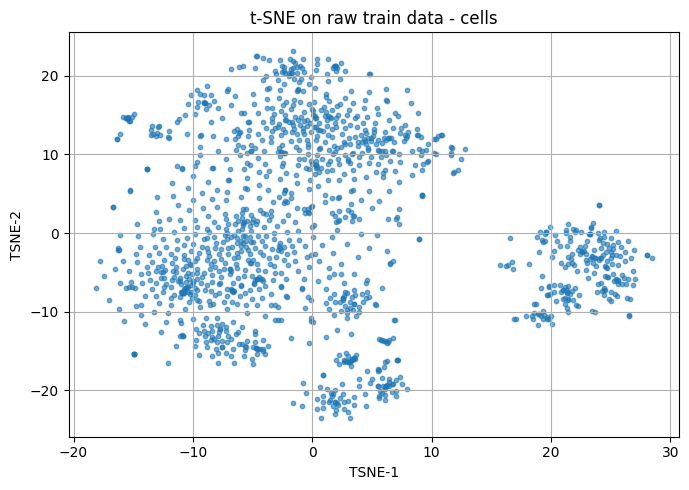

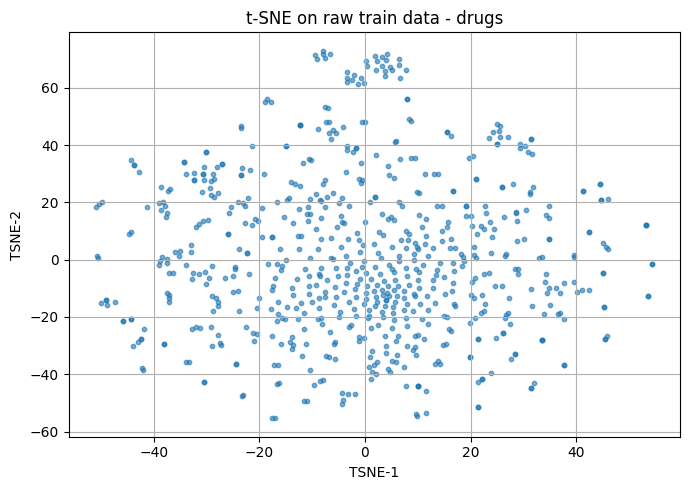

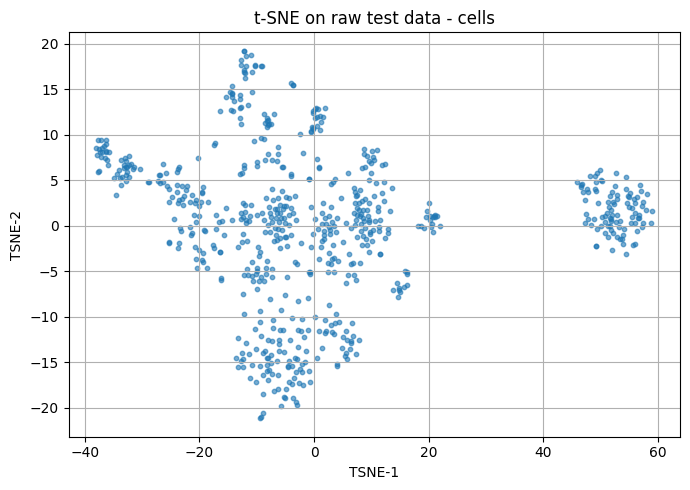

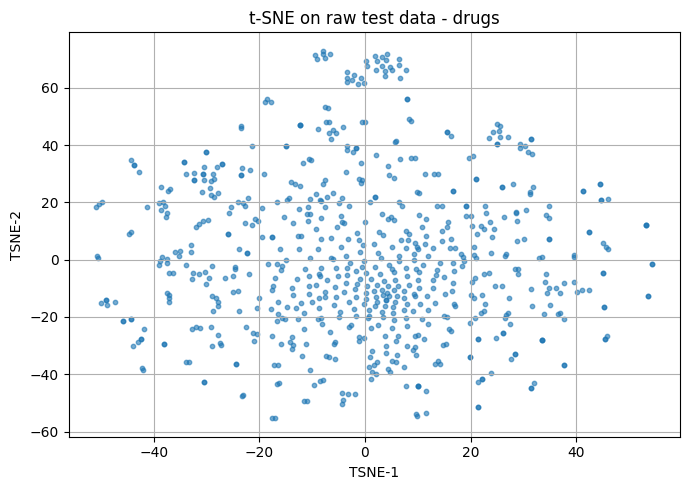

Run 0
Epoch [1/25], Train Loss: 0.2619, Val Loss: 0.1740
Epoch [2/25], Train Loss: 0.0739, Val Loss: 0.1428
Epoch [3/25], Train Loss: 0.0684, Val Loss: 0.1219
Epoch [4/25], Train Loss: 0.0668, Val Loss: 0.1234
Epoch [5/25], Train Loss: 0.0660, Val Loss: 0.1168


KeyboardInterrupt: 

In [5]:
def run(k, is_test=False ):

    # Load raw data
    train_data, _ = RawDataLoader.load_data(data_modalities=DATA_MODALITIES,
                                            raw_file_directory=RAW_BOTH_DATA_FOLDER,
                                            screen_file_directory=None,
                                            sep="\t")

    print(train_data.keys())
    for key, df in train_data.items():
        print(f"{key}: {df.shape}")
    

    # Load test data if applicable
    if is_test:
        test_data, _ = RawDataLoader.load_data(data_modalities=DATA_MODALITIES,
                                                raw_file_directory=TCGA_DATA_FOLDER,
                                                screen_file_directory=None,
                                                sep="\t")

        print(test_data.keys())
        for key, df in test_data.items():
            print(f"{key}: {df.shape}")
        
        train_data, test_data = RawDataLoader.data_features_intersect(train_data, test_data)


    # Prepare input data for training
    X_cell_train, X_drug_train, cell_train_sizes, drug_train_sizes = RawDataLoader.get_unique_entities(train_data)

    if is_test:
        X_cell_test, X_drug_test, cell_test_sizes, drug_test_sizes = RawDataLoader.get_unique_entities(test_data)

    # Sparcity check
    print("X_cell_train sparsity:", (X_cell_train == 0).sum().sum() / X_cell_train.size)
    print("X_drug_train sparsity:", (X_drug_train == 0).sum().sum() / X_drug_train.size)
    
    if is_test:
        print("X_cell_test sparsity:", (X_cell_test == 0).sum().sum() / X_cell_test.size)
        print("X_drug_test sparsity:", (X_drug_test == 0).sum().sum() / X_drug_test.size)

    # plot t-SNE raw data
    plot_tsne(X_cell_train.values, "t-SNE on raw train data - cells")
    plot_tsne(X_drug_train.values, "t-SNE on raw train data - drugs")
    if is_test:
        plot_tsne(X_cell_test.values, "t-SNE on raw test data - cells")
        plot_tsne(X_drug_test.values, "t-SNE on raw test data - drugs")
    
    # Loop over k runs
    for i in range(k):
        print('Run {}'.format(i))

        if is_test:

            # Train and evaluate the reconstruction on test data
            ae_cell = train_autoencoder(X_cell_train, X_cell_test, cell_train_sizes, cell_test_sizes, 
                                        latent_dim=700, save_path="encoder_cell.pth", epochs=25, batch_size=64)
            ae_drug = train_autoencoder(X_drug_train, X_drug_test, drug_train_sizes, drug_test_sizes, 
                                        latent_dim=50, save_path="encoder_drug.pth", epochs=25, batch_size=64)

        else:
            # Train and evaluate the reconstruction on a train_test_split of the training dataset
            ae_cell = cv_train_autoencoder(X_train=X_cell_train, X_train_sizes=cell_train_sizes, 
                                           latent_dim=100, save_path="encoder_cell.pth", device=device, epochs=25, k=2, batch_size=64)
            ae_drug = cv_train_autoencoder(X_train=X_drug_train, X_train_sizes=drug_train_sizes, 
                                           latent_dim=25, save_path="encoder_drug.pth", device=device, epochs=25, k=2, batch_size=64)

        with torch.no_grad():
            
            x_cell_tensor = torch.tensor(X_cell_train.values, dtype=torch.float32).to(device)
            x_drug_tensor = torch.tensor(X_drug_train.values, dtype=torch.float32).to(device)
            
            _, _, _, z_cell = ae_cell(x_cell_tensor, return_latent=True)
            _, _, _, z_drug = ae_drug(x_drug_tensor, return_latent=True)

        sparsity_cell = (z_cell == 0).float().mean().item()
        sparsity_drug = (z_drug == 0).float().mean().item()
        print(f"Sparsity z_cell: {sparsity_cell:.4f}, z_drug: {sparsity_drug:.4f}")

        print("z_cell std:", z_cell.std().item())
        print("z_drug std:", z_drug.std().item())

        print("z_cell shape:", z_cell.shape)
        print("z_drug shape:", z_drug.shape)

        # Visualisation t-SNE latent space
        plot_tsne(z_cell.detach().cpu().numpy(), "t-SNE - encoded cells (train data)")
        plot_tsne(z_drug.detach().cpu().numpy(), "t-SNE - encoded drugs (train data)")


if __name__ == "__main__":
    torch.manual_seed(RANDOM_SEED)
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    run(1, is_test=True)
    